2. Gợi ý biến vi mô
Nếu bạn có thể thu thập thêm dữ liệu từ báo cáo tài chính của VCB, hoặc từ nguồn VNStock, thì nên thêm:
EPS (Earnings per Share) — lợi nhuận mỗi cổ phiếu.
P/E (Price/Earnings ratio) — mức định giá thị trường.
ROA, ROE — khả năng sinh lợi của tài sản và vốn chủ.
NIM (Net Interest Margin) — chênh lệch lãi suất cho vay – huy động.
Tăng trưởng tín dụng (Loan growth) — cho thấy sức mở rộng hoạt động cho vay.

1. Vix mo:
Chính sách tiền tệ (lãi suất tái chiết khấu, lãi suất cho vay, lãi suất huy động).
Thanh khoản hệ thống (tăng trưởng M2, tỷ lệ dự trữ bắt buộc).
Tỷ giá USD/VND (ảnh hưởng đến hoạt động xuất nhập khẩu, dự trữ ngoại hối).
Chỉ số VNIndex hoặc ngành ngân hàng (đại diện cho tâm lý thị trường chung).
Lạm phát (CPI) và tăng trưởng GDP (ảnh hưởng đến sức mua và tín dụng).

yeu to anh huong:
1. gia lich su
2. kinh te vi mo, vi mo
3. chinh sach nha nuoc
4. chinh sach cong ty

# **0. Setup**

## 0.1. Library and Environment

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re

np.random.seed(42)
pd.set_option("display.max_columns", None)

FIG_DIR = "fig"

## 0.2. Data Loading

In [3]:
raw_data = yf.download(
    tickers = "^SP500-40",
    start = "1900-01-01",
    end = "2025-01-01",
    interval = "1D",
    progress=False,
    auto_adjust=True
)

raw_data.columns = raw_data.columns.get_level_values(0)
raw_data = raw_data[['Open', 'High', 'Low', 'Close', 'Volume']]
raw_data.reset_index(inplace=True)
raw_data.columns.name = None
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

## 0.3. Data Augmentation

### 0.3.1. Economic Index

In [4]:
alias = {
    "^VIX": "VIX",
    "^TNX": "US10Y",
    "DX-Y.NYB": "DXY",
    "CL=F": "OIL",
    "GC=F": "GOLD"
}

def get_weekly_indicator(ticker, start, end):
    data = yf.download(
        ticker,
        start=start,
        end=end,
        interval="1D",
        auto_adjust=True,
        progress=False,
    )['Close']

    data = data.resample('W-FRI').last()
    clean_name = alias.get(ticker, re.sub(r'[^A-Za-z0-9_]+', '', ticker))
    data.columns = [clean_name]
    data = data.reset_index().rename(columns={'Date': 'Date'})
    return data

start_date = raw_data['Date'].min().strftime('%Y-%m-%d')
end_date   = raw_data['Date'].max().strftime('%Y-%m-%d')

vix = get_weekly_indicator("^VIX", start_date, end_date)        # Volatility Index
us10y = get_weekly_indicator("^TNX", start_date, end_date)      # TPCP 10 Years
dxy = get_weekly_indicator("DX-Y.NYB", start_date, end_date)    # US Dollar Index
oil = get_weekly_indicator("CL=F", start_date, end_date)        # Raw Diesel WTI
gold = get_weekly_indicator("GC=F", start_date, end_date)       # Gold

for indicator in [vix, us10y, dxy, oil, gold]:
    aug_data = pd.merge_asof(raw_data.sort_values('Date'), indicator.sort_values('Date'), on='Date')

### 0.3.2. Financial Indicators

In [5]:
delta = aug_data['Close'].diff()
abs_diff = delta.abs()

# MA, EMA
for w in [20, 60, 120, 240]:
    aug_data[f'MA_{w}'] = aug_data['Close'].rolling(window=w).mean()
    aug_data[f'EMA_{w}'] = aug_data['Close'].ewm(span=w, adjust=False).mean()

# MAE
for w in [5, 20, 60, 120]:
    aug_data[f'MAE_{w}'] = abs_diff.rolling(window=w).mean()


# MACD
ema12 = aug_data['Close'].ewm(span=12, adjust=False).mean()
ema26 = aug_data['Close'].ewm(span=26, adjust=False).mean()
ema60 = aug_data['Close'].ewm(span=60, adjust=False).mean()
ema120 = aug_data['Close'].ewm(span=120, adjust=False).mean()

aug_data['MACD'] = ema12 - ema26
aug_data['MACD_long'] = ema60 - ema120
aug_data['Signal'] = aug_data['MACD'].ewm(span=9, adjust=False).mean()
aug_data['Signal_long'] = aug_data['MACD_long'].ewm(span=45, adjust=False).mean()

# RSI
delta = aug_data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
aug_data['RSI'] = 100 - (100 / (1 + rs))

for p in [7, 14, 28]:
    avg_gain = gain.rolling(p).mean()
    avg_loss = loss.rolling(p).mean()
    rs = avg_gain / avg_loss
    aug_data[f'RSI_{p}'] = 100 - (100 / (1 + rs))

# **1. EDA**

## 1.1. Data Summary

In [6]:
aug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7970 entries, 0 to 7969
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         7970 non-null   datetime64[ns]
 1   Open         7970 non-null   float64       
 2   High         7970 non-null   float64       
 3   Low          7970 non-null   float64       
 4   Close        7970 non-null   float64       
 5   Volume       7970 non-null   int64         
 6   GOLD         6117 non-null   float64       
 7   MA_20        7951 non-null   float64       
 8   EMA_20       7970 non-null   float64       
 9   MA_60        7911 non-null   float64       
 10  EMA_60       7970 non-null   float64       
 11  MA_120       7851 non-null   float64       
 12  EMA_120      7970 non-null   float64       
 13  MA_240       7731 non-null   float64       
 14  EMA_240      7970 non-null   float64       
 15  MAE_5        7965 non-null   float64       
 16  MAE_20

In [7]:
aug_data.describe()

,Date,Open,High,Low,Close,Volume,GOLD,MA_20,EMA_20,MA_60,EMA_60,MA_120,EMA_120,MA_240,EMA_240,MAE_5,MAE_20,MAE_60,MAE_120,MACD,MACD_long,Signal,Signal_long,RSI,RSI_7,RSI_14,RSI_28
count,7970,7970.000000,7970.000000,7970.000000,7970.000000,7.970000e+03,6117.000000,7951.000000,7970.000000,7911.000000,7970.000000,7851.000000,7970.000000,7731.000000,7970.000000,7965.000000,7950.000000,7910.000000,7850.000000,7970.000000,7970.000000,7970.000000,7970.000000,7956.000000,7963.000000,7956.000000,7942.000000
mean,2009-02-25 19:13:15.884567040,344.056146,346.288598,341.757695,344.093083,6.452342e+07,1159.068726,343.822286,343.248901,343.223375,341.513707,342.485780,339.103768,341.402939,334.746387,3.485447,3.485210,3.486299,3.489214,0.625011,2.409939,0.625876,2.328974,53.531035,53.702995,53.531035,53.272431
min,1993-05-04 00:00:00,81.739998,85.930000,78.470001,81.739998,0.000000e+00,257.899994,99.147000,99.724908,101.405000,101.790625,104.070750,103.512743,105.691125,105.085986,0.121999,0.316500,0.483501,0.558417,-47.619195,-37.509060,-41.028616,-35.196490,2.186875,0.000000,2.186875,9.019027
25%,2001-03-23 18:00:00,221.197502,222.467506,219.877495,221.264999,0.000000e+00,628.700012,220.962000,220.420285,219.743833,216.835105,219.885583,213.927065,225.294604,209.833979,1.689999,1.917755,2.023877,2.156813,-1.460076,-1.337150,-1.192359,-1.272179,42.175763,36.832717,42.175763,45.314818
50%,2009-02-26 12:00:00,332.844986,334.225006,330.879990,332.824997,1.408100e+06,1230.900024,333.135001,332.213942,330.911667,329.253828,329.270833,326.960886,327.153167,323.832939,2.811987,2.902251,2.979167,2.993999,1.033932,3.336749,0.999584,3.226207,53.709332,53.701021,53.709332,53.252909
75%,2017-01-25 18:00:00,433.495003,436.472496,430.507507,433.575005,1.981045e+07,1616.300049,432.966000,432.960106,432.497999,430.365569,432.645792,432.311732,434.807791,427.602393,4.426001,4.515246,4.652752,4.704001,3.435770,8.020334,3.287805,7.695057,64.908759,71.196877,64.908759,61.260793
max,2024-12-31 00:00:00,854.250000,857.109985,851.289978,851.979980,1.335046e+09,2740.899902,835.313501,830.505641,806.952665,802.998564,769.021499,774.446570,722.637165,729.503808,37.620001,24.299998,14.902166,10.773832,18.004074,36.935660,16.728409,34.841029,96.628614,100.000000,96.628614,85.733906
std,NaN,148.948165,150.001642,147.930508,148.984978,1.251408e+08,580.586704,147.780116,147.927656,145.205981,145.880529,141.869858,143.208299,135.841462,138.759418,2.765830,2.381945,2.128583,1.977398,5.316315,10.658436,4.985141,10.019558,16.108182,22.859727,16.108182,11.377552


## 1.2. Preprocessing

In [8]:
print(f"Null value check: \n{aug_data.isna().sum()}")

Null value check: 
Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GOLD           1853
MA_20            19
EMA_20            0
MA_60            59
EMA_60            0
MA_120          119
EMA_120           0
MA_240          239
EMA_240           0
MAE_5             5
MAE_20           20
MAE_60           60
MAE_120         120
MACD              0
MACD_long         0
Signal            0
Signal_long       0
RSI              14
RSI_7             7
RSI_14           14
RSI_28           28
dtype: int64


In [9]:
duplicate_count = aug_data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


In [22]:
first_valid_index = aug_data.dropna().index.min()
cropped_data = aug_data.loc[first_valid_index:].reset_index(drop=True)
# cropped_data.drop(columns=['Open', 'High', 'Low'], inplace=True)
print("\nNew shape:", cropped_data.shape)


New shape: (6117, 27)


## 1.3. Statistical Analysis

In [23]:
data = cropped_data.copy()

def statistical_analysis(df: pd.DataFrame) -> dict:
    result = {
        "mean": df.mean(),
        "median": df.median(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "q1": df.quantile(0.25),
        "q3": df.quantile(0.75),
        "iqr": df.quantile(0.75) - df.quantile(0.25)
    }

    return result

stats_summary = pd.DataFrame({
    col: statistical_analysis(data[col])
    for col in data.select_dtypes(include=['number']).columns
})
stats_summary

,Open,High,Low,Close,Volume,GOLD,MA_20,EMA_20,MA_60,EMA_60,MA_120,EMA_120,MA_240,EMA_240,MAE_5,MAE_20,MAE_60,MAE_120,MACD,MACD_long,Signal,Signal_long,RSI,RSI_7,RSI_14,RSI_28
mean,383.479811,386.388532,380.485099,383.527937,8.406925e+07,1159.068726,382.847593,382.836802,381.319636,381.363467,379.190882,379.315679,375.271584,375.749854,3.796970,3.794001,3.789462,3.788435,0.521517,2.047788,0.526913,1.973904,53.042554,53.256902,53.042554,52.825080
median,377.029999,379.230011,375.339996,377.049988,4.876200e+06,1230.900024,377.157997,377.626911,377.563166,377.362023,374.756332,374.610176,367.744750,365.794745,3.009998,3.092999,3.185666,3.260166,1.132105,3.253630,1.064984,3.208500,53.258472,53.112360,53.258472,52.575465
std,140.181646,140.818675,139.611305,140.219075,1.369723e+08,580.586704,138.874069,138.709986,136.000365,135.729096,132.332975,131.725712,125.946230,124.822431,2.869145,2.426468,2.118348,1.935950,5.688858,11.746926,5.343697,11.071990,15.813056,22.412895,15.813056,11.077456
min,81.739998,85.930000,78.470001,81.739998,0.000000e+00,257.899994,99.147000,101.031519,115.727167,123.817275,135.834749,149.402262,157.073125,183.550977,0.174002,0.619501,1.231834,1.410250,-47.619195,-37.509060,-41.028616,-35.196490,2.186875,0.000000,2.186875,9.019027
max,854.250000,857.109985,851.289978,851.979980,1.335046e+09,2740.899902,835.313501,830.505641,806.952665,802.998564,769.021499,774.446570,722.637165,729.503808,37.620001,24.299998,14.902166,10.773832,18.004074,36.935660,16.728409,34.841029,96.628614,100.000000,96.628614,85.733906
q1,294.010010,295.940002,290.920013,293.910004,0.000000e+00,628.700012,293.778000,293.946882,295.115999,295.881584,298.386584,299.769179,301.847543,304.209836,1.972003,2.156003,2.206837,2.294000,-1.827676,-2.415168,-1.640798,-2.321164,41.889780,36.811588,41.889780,45.127760
q3,462.179993,465.440002,458.149994,462.179993,1.686484e+08,1616.300049,459.878998,459.626284,457.112334,458.392368,455.381667,455.210980,448.377625,446.440136,4.663998,4.768005,5.084666,4.927250,3.594993,8.097415,3.413676,7.674360,63.995328,70.351305,63.995328,60.478940
iqr,168.169983,169.500000,167.229980,168.269989,1.686484e+08,987.600037,166.100998,165.679403,161.996336,162.510784,156.995083,155.441802,146.530083,142.230300,2.691995,2.612003,2.877829,2.633250,5.422669,10.512583,5.054474,9.995524,22.105548,33.539717,22.105548,15.351180


In [24]:
data.describe()

,Date,Open,High,Low,Close,Volume,GOLD,MA_20,EMA_20,MA_60,EMA_60,MA_120,EMA_120,MA_240,EMA_240,MAE_5,MAE_20,MAE_60,MAE_120,MACD,MACD_long,Signal,Signal_long,RSI,RSI_7,RSI_14,RSI_28
count,6117,6117.000000,6117.000000,6117.000000,6117.000000,6.117000e+03,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000
mean,2012-11-01 13:40:10.004904448,383.479811,386.388532,380.485099,383.527937,8.406925e+07,1159.068726,382.847593,382.836802,381.319636,381.363467,379.190882,379.315679,375.271584,375.749854,3.796970,3.794001,3.789462,3.788435,0.521517,2.047788,0.526913,1.973904,53.042554,53.256902,53.042554,52.825080
min,2000-09-01 00:00:00,81.739998,85.930000,78.470001,81.739998,0.000000e+00,257.899994,99.147000,101.031519,115.727167,123.817275,135.834749,149.402262,157.073125,183.550977,0.174002,0.619501,1.231834,1.410250,-47.619195,-37.509060,-41.028616,-35.196490,2.186875,0.000000,2.186875,9.019027
25%,2006-10-04 00:00:00,294.010010,295.940002,290.920013,293.910004,0.000000e+00,628.700012,293.778000,293.946882,295.115999,295.881584,298.386584,299.769179,301.847543,304.209836,1.972003,2.156003,2.206837,2.294000,-1.827676,-2.415168,-1.640798,-2.321164,41.889780,36.811588,41.889780,45.127760
50%,2012-10-31 00:00:00,377.029999,379.230011,375.339996,377.049988,4.876200e+06,1230.900024,377.157997,377.626911,377.563166,377.362023,374.756332,374.610176,367.744750,365.794745,3.009998,3.092999,3.185666,3.260166,1.132105,3.253630,1.064984,3.208500,53.258472,53.112360,53.258472,52.575465
75%,2018-11-27 00:00:00,462.179993,465.440002,458.149994,462.179993,1.686484e+08,1616.300049,459.878998,459.626284,457.112334,458.392368,455.381667,455.210980,448.377625,446.440136,4.663998,4.768005,5.084666,4.927250,3.594993,8.097415,3.413676,7.674360,63.995328,70.351305,63.995328,60.478940
max,2024-12-31 00:00:00,854.250000,857.109985,851.289978,851.979980,1.335046e+09,2740.899902,835.313501,830.505641,806.952665,802.998564,769.021499,774.446570,722.637165,729.503808,37.620001,24.299998,14.902166,10.773832,18.004074,36.935660,16.728409,34.841029,96.628614,100.000000,96.628614,85.733906
std,NaN,140.181646,140.818675,139.611305,140.219075,1.369723e+08,580.586704,138.874069,138.709986,136.000365,135.729096,132.332975,131.725712,125.946230,124.822431,2.869145,2.426468,2.118348,1.935950,5.688858,11.746926,5.343697,11.071990,15.813056,22.412895,15.813056,11.077456


## 1.4. Visualization

### 1.4.1. Candlestick Chart
Candlestick charts are a classic tool in financial analysis, helping to easily identify trends, fluctuations and market sentiment in each session.


In [25]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Bar(
        x=data['Date'],
        y=data['Volume'],
        name='Volume',
        marker_color='blue',
        opacity=0.4
    ),
    secondary_y=False
)

fig.update_yaxes(showgrid=False, secondary_y=True)
fig.update_layout(
    title='S&P 500 Financials (Sector) (^SP500-40)',
    xaxis_title='Date',
    yaxis_title='Volume',
    yaxis2_title='Price',
    xaxis_rangeslider_visible=False,
    template='seaborn',
    width=2000,
    height=600,
)

fig.show()

### 1.4.2. Boxplot

Boxplots help detect outlier data, an important step in EDA to ensure that the subsequent analysis model is not affected by unusual values.

/tmp/ipykernel_654521/2987514179.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




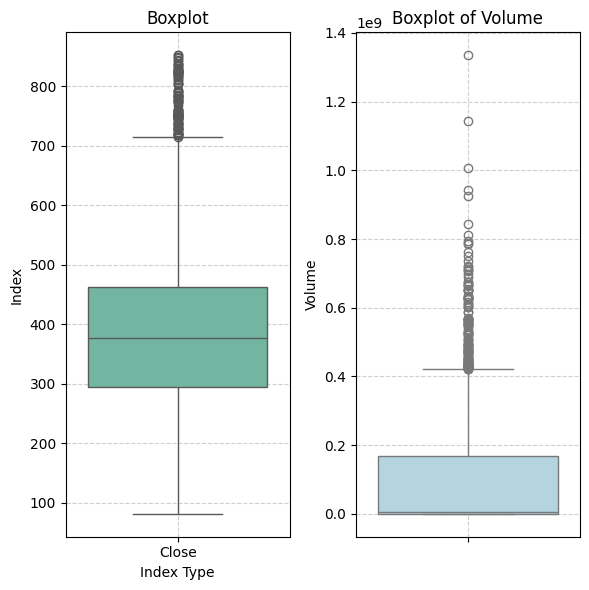

In [29]:
cols = ["Close"]

data_melted = data.melt(value_vars=cols, var_name="Index Type", value_name="Index")
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.boxplot(
    x="Index Type", y="Index", data=data_melted,
    ax=axes[0], palette="Set2", order=cols
)
axes[0].set_title("Boxplot")
axes[0].set_ylabel("Index")
axes[0].grid(True, linestyle="--", alpha=0.6)

sns.boxplot(
    y=data["Volume"], color="lightblue", ax=axes[1]
)
axes[1].set_title("Boxplot of Volume")
axes[1].set_xlabel("")
axes[1].set_ylabel("Volume")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()

box_path = os.path.join(FIG_DIR, "boxplot.png")
plt.savefig(box_path, dpi=150)
plt.show()
plt.close()

### 1.4.3. Histogram

Histogram is the basic chart to identify the distribution of data.

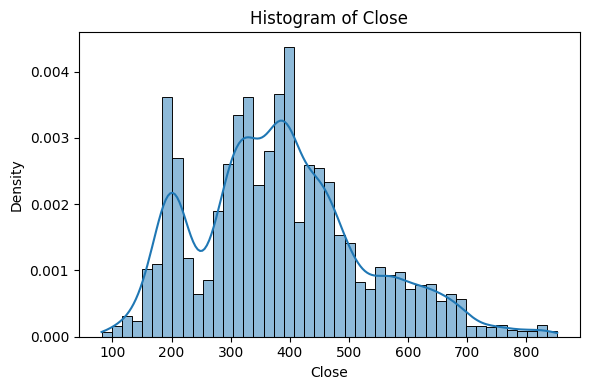

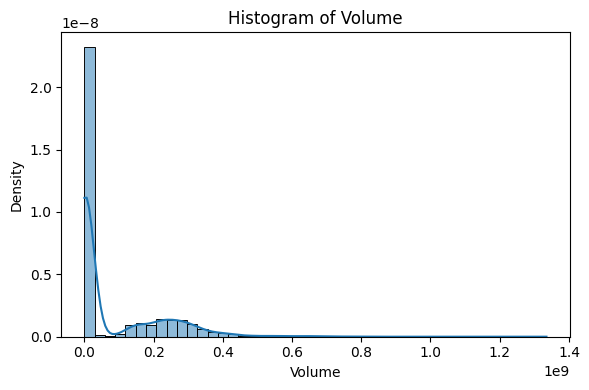

In [30]:
cols = ["Close", "Volume"]

for col in cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col].dropna(), kde=True, stat="density", bins=45)
    plt.title(f"Histogram of {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Density")
    plt.tight_layout()

    hist_path = os.path.join(FIG_DIR, f"hist_{col}.png")
    plt.savefig(hist_path, dpi=150)
    plt.show()
    plt.close()


### 1.4.4. Line Chart

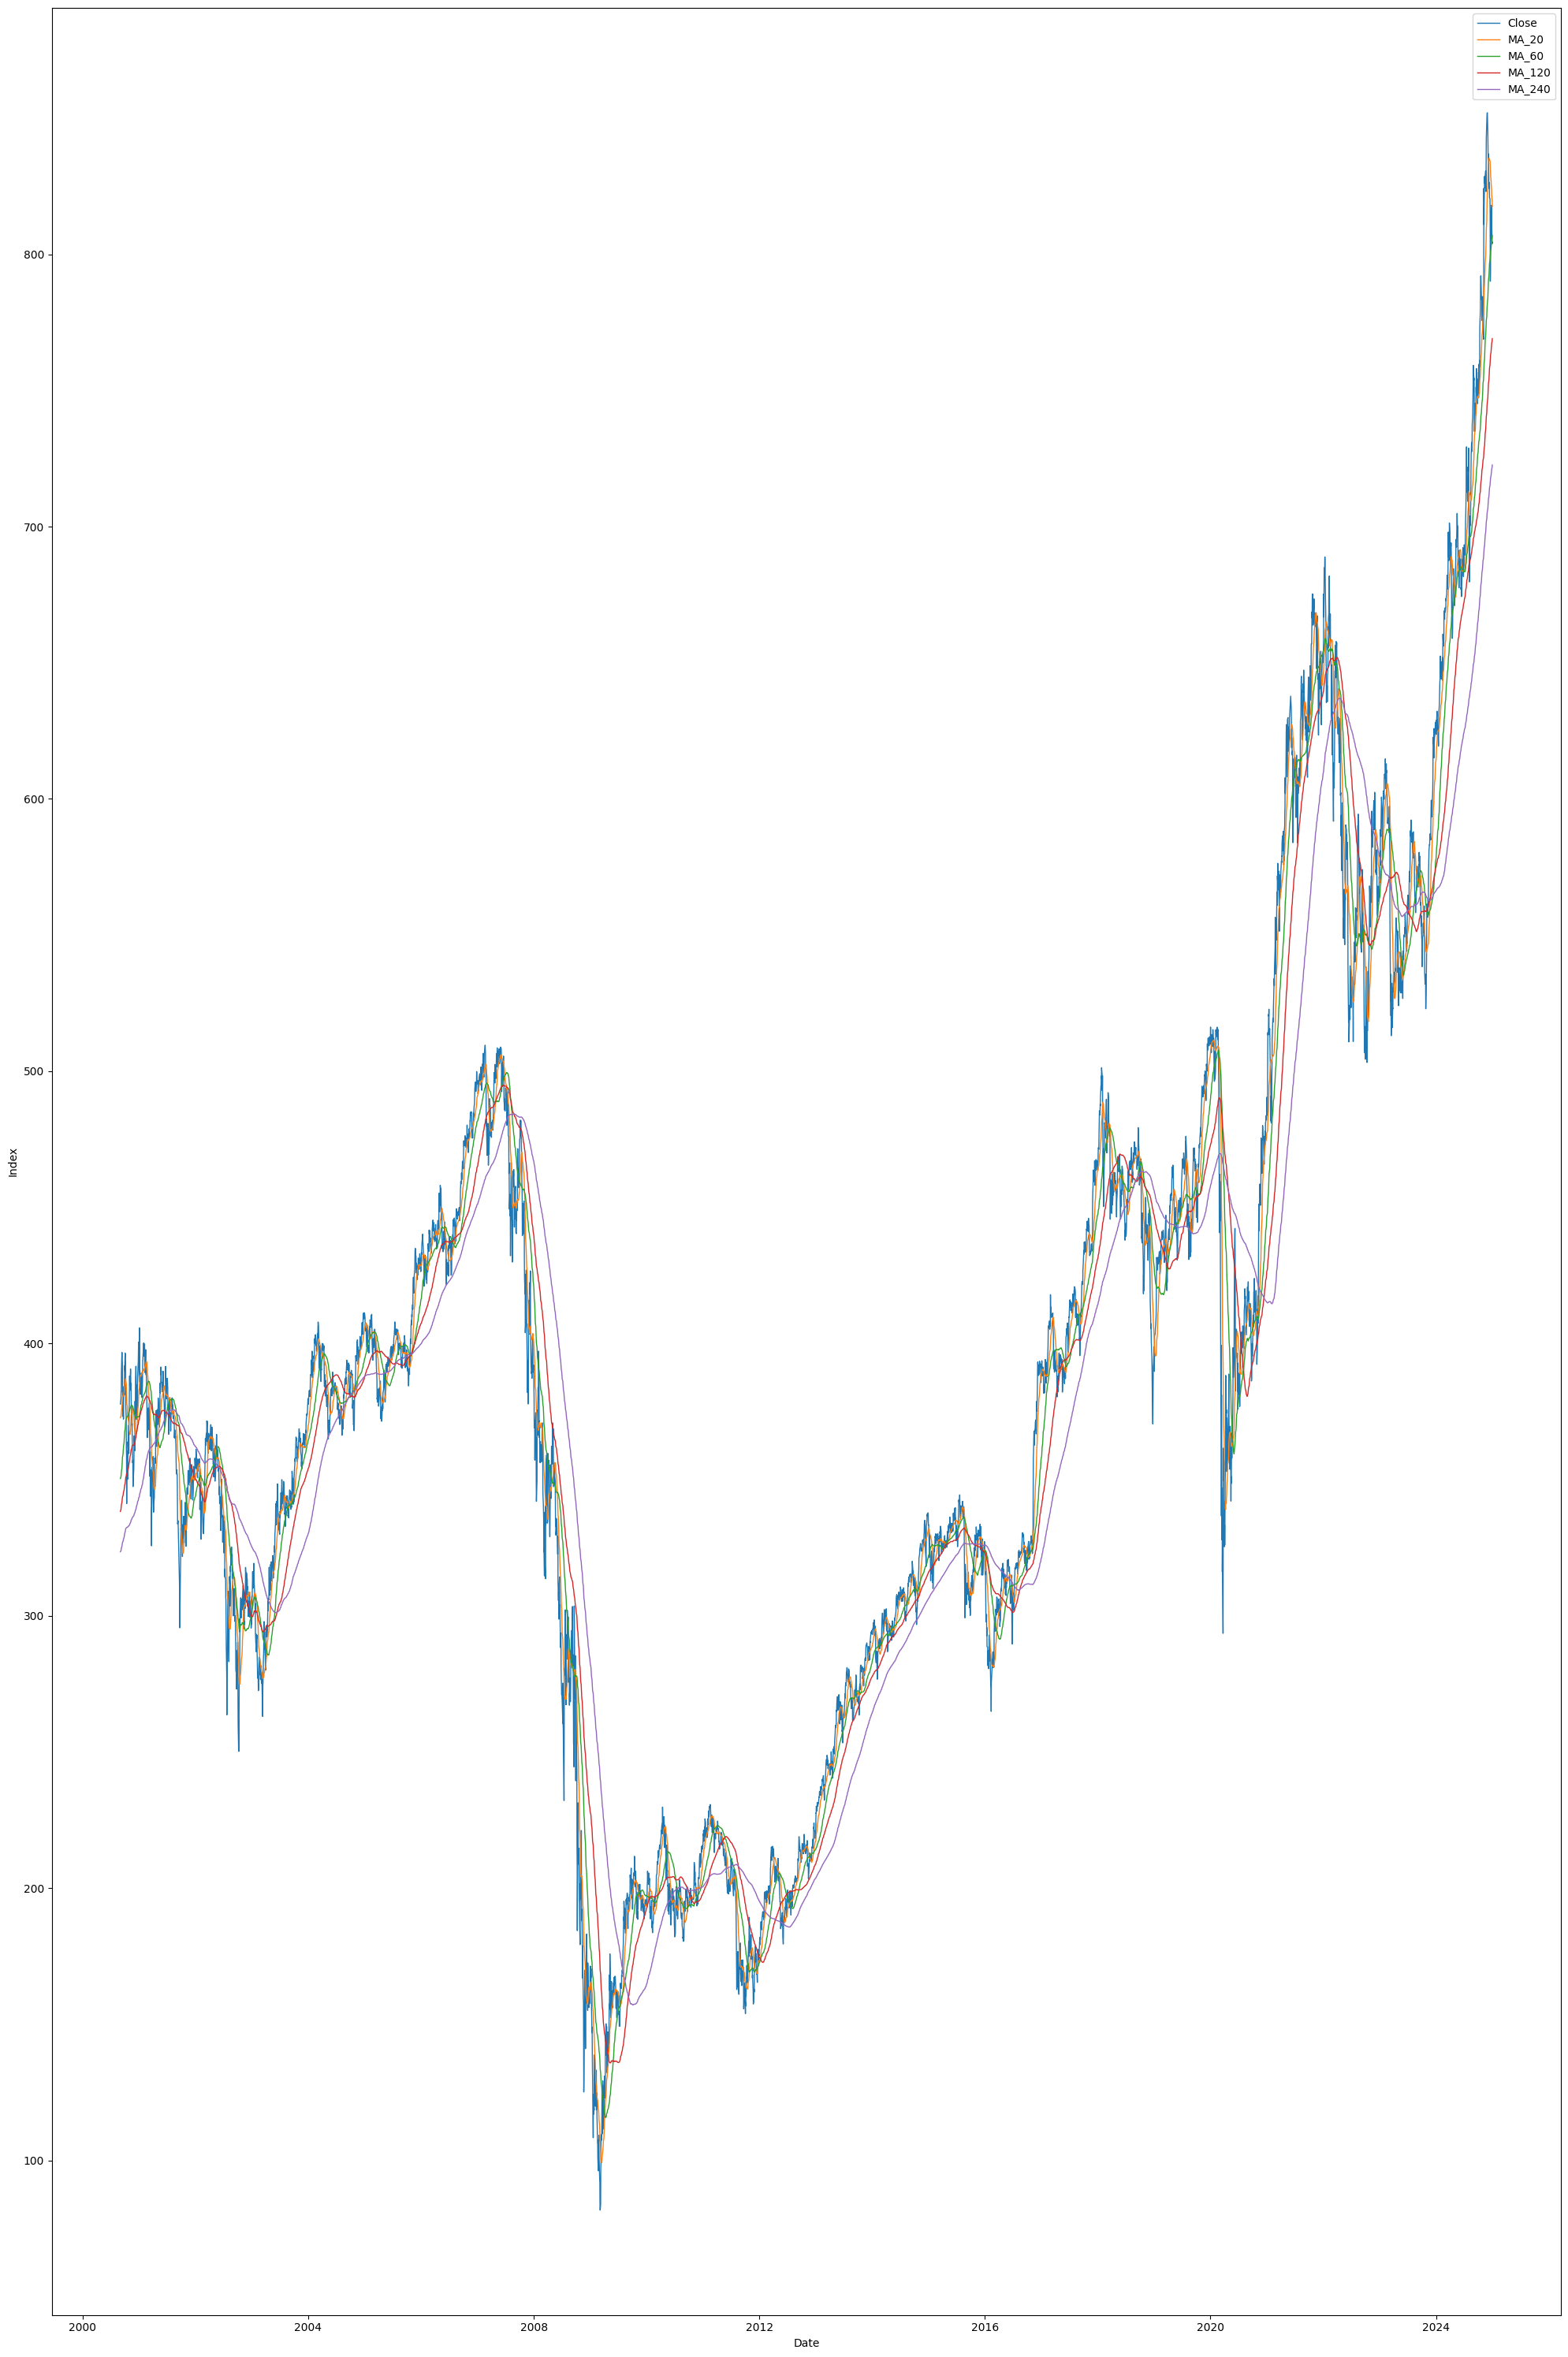

In [41]:
plt.figure(figsize=(20,30))
plt.plot(data["Date"], data["Close"], label="Close", linewidth=1)

for w in [20, 60, 120, 240]:
    plt.plot(data["Date"], data[f"MA_{w}"], label=f"MA_{w}", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
line_path = os.path.join(FIG_DIR, "line_trend.png")
plt.savefig(line_path, dpi=150)
plt.close()

# Moving Average

### 1.4.5. Heatmap

In [33]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'GOLD', 'MA_20',
       'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120', 'MA_240', 'EMA_240',
       'MAE_5', 'MAE_20', 'MAE_60', 'MAE_120', 'MACD', 'MACD_long', 'Signal',
       'Signal_long', 'RSI', 'RSI_7', 'RSI_14', 'RSI_28'],
      dtype='object')

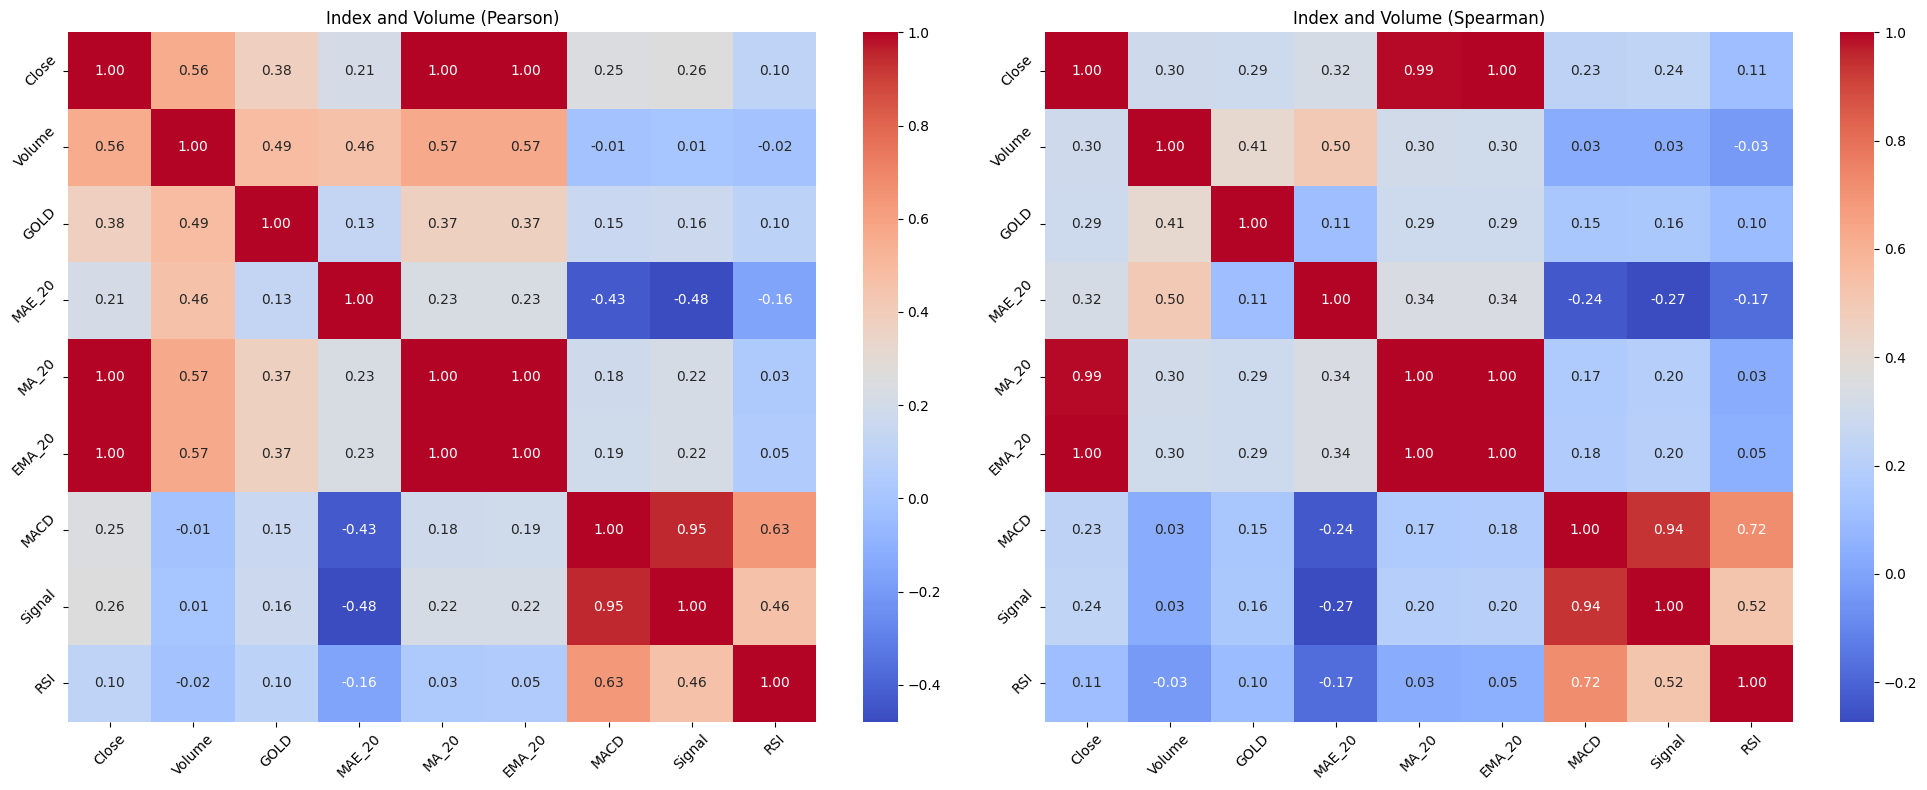

In [40]:
corr_pear = data[[
        'Close', 'Volume', 'GOLD',
        'MAE_20', 'MA_20', 'EMA_20',
        'MACD', 'Signal', 'RSI'
    ]
].corr(method="pearson")

corr_spear = data[[
        'Close', 'Volume', 'GOLD',
        'MAE_20', 'MA_20', 'EMA_20',
        'MACD', 'Signal', 'RSI'
    ]
].corr(method="spearman")

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(corr_spear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Spearman)")

plt.tight_layout()
plt.show()

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore

X = data[["Open", "High", "Low", "Close", "Volume"]].dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Feature          VIF
0    Open  5682.586688
1    High  7972.580946
2     Low  5292.481364
3   Close  6417.182648
4  Volume     1.815613


In [42]:
data.to_csv("data/v1.csv")